
def rnd():
    return np.random.normal()
def bivariate_ts(p,length):

    ts = np.zeros(length)
    ts[0] = rnd()
    for i in range(1,length):
        r = rnd()
        ts[i] = ts[i-1]*p + r*np.sqrt(1-p**2)
    return ts

# Autokorrelationsfunktion für Zeitreihe ts
@njit
def A(ts,k):
    N = len(ts)
    ts1 = ts[0:N-k]
    ts2 = ts[k:N]
    #a = np.dot(ts1,ts2)/(N-k)
    a = 0
    for i in range(N-k):
        a += ts1[i]*ts2[i]
    a /= (N-k)
    b = np.mean(ts1)*np.mean(ts2)
    #b = np.mean(ts)**2
    var = np.var(ts)

    return (a-b)/var

# integrierte Autokorrelationszeit für Zeitreihe ts, k_max wird manuell festgelegt
@njit
def t_int_kmax(ts, k_max):
    N = len(ts)
    t = 0.5
    stop = False
    if k_max == 0:
        k_max = N
        stop = True
    for k in range(1,k_max):
        t += A(ts,k)#*(1-k/N)
        if stop:
            if k > 6*t:
                break
    return t

# integrierte Autokorrelationszeit für Zeitreihe ts, k_max wird nach Kriterium crit festgelegt

@njit
def t_int(ts):
    N = len(ts)
    t = 0.5
    dt = 0
    for k in range(1,N):
        t += A(ts,k)#*(1-k/N)
        if crit(t,k):
            dt = err_t_int(t,k,N)
            break
    return t,dt

@njit
def crit(t,k):
    return (k > 6*t)

# Fehler für integrierte Autokorrelationszeit nach Kriterium crit
@njit
def err_t_int(t_int,k_max,N):
    return t_int*np.sqrt(2*(2*k_max+1)/N)


In [73]:
import numpy as np
from numba import njit
@njit
def autocorrelation_function1(ts,k):
    x = ts[:-k]
    y = ts[k:]
    return np.corrcoef(x,y)[0,1]

@njit
def autocorrelation_function2(ts,k):
    x = ts
    y = np.roll(ts,k)    
    return np.corrcoef(x,y)[0,1]
@njit
def A(ts,k):
    N = len(ts)
    ts1 = ts[0:N-k]
    ts2 = ts[k:N]
    #a = np.dot(ts1,ts2)/(N-k)
    a = 0
    for i in range(N-k):
        a += ts1[i]*ts2[i]
    a /= (N-k)
    b = np.mean(ts1)*np.mean(ts2)
    #b = np.mean(ts)**2
    var = np.var(ts)

    return (a-b)/var

In [74]:
# bivariate ts

@njit
def rnd_gauss_0_1():
    return np.random.normal(0,1)
@njit
def bivariate_ts(p,length):

    ts = np.zeros(length)
    ts[0] = rnd_gauss_0_1()
    for i in range(1,length):
        r = rnd()
        ts[i] = ts[i-1]*p + r*np.sqrt(1-p**2)
    t_int = 0.5 * (1+p)/(1-p)
    return ts, t_int

In [75]:
@njit
def t_int__bin(ts,bin_count):
    N = len(ts)
    bin_size = N//bin_count
    N_new = bin_size*bin_count
    ts_new = ts[-N_new:]
    var_ges = np.var(ts_new)
    mean_bin = np.zeros(bin_count)
    for i in range(bin_count):
        mean_bin[i] = np.mean(ts[i*bin_size:(i+1)*bin_size])
    var_bin = np.var(mean_bin)
    t = var_bin/var_ges*bin_size/2

    return t
@njit
def binning(ts,bin_count):
    N = len(ts)
    bin_size = N//bin_count
    N_new = bin_size*bin_count
    ts_new = ts[-N_new:]
    mean_ts = np.mean(ts_new)
    var_ts = np.var(ts_new)
    mean_bin = np.zeros(bin_count)
    for i in range(bin_count):
        mean_bin[i] = np.mean(ts[i*bin_size:(i+1)*bin_size])
    var_bin = np.var(mean_bin)
    t_int_bin = var_bin/var_ts*bin_size/2
    return mean_ts,np.sqrt(var_bin/bin_count),t_int_bin

@njit
def err_t_int(t_int,k_max,N):
    return t_int*np.sqrt(2*(2*k_max+1)/N)
@njit
def t_int(ts):
    N = len(ts)
    t = 0.5
    dt = 0
    ts_t = np.zeros(N)
    t_estimate = 0
    for k in range(1,N):
        t += A(ts,k)#*(1-k/N)
        if crit(t,k):
            t_estimate = t
            dt = err_t_int(t,k,N)
        ts_t[k] = t
        
    return t_estimate,dt, ts_t

@njit 
def t_int_np(ts):
    N = len(ts)
    t = 0.5
    dt = 0
    ts_t = np.zeros(N)
    t_estimate = 0
    for k in range(1,N):
        t += autocorrelation_function1(ts,k)
        if crit(t,k):
            t_estimate = t
            dt = err_t_int(t,k,N)
        ts_t[k] = t
    return t_estimate,dt, ts_t

@njit
def crit(t,k):
    return (k > 6*t)

@njit
def A(ts,k):
    N = len(ts)
    ts1 = ts[0:N-k]
    ts2 = ts[k:N]
    #a = np.dot(ts1,ts2)/(N-k)
    a = 0
    for i in range(N-k):
        a += ts1[i]*ts2[i]
    a /= (N-k)
    b = np.mean(ts1)*np.mean(ts2)
    #b = np.mean(ts)**2
    var = np.var(ts)

    return (a-b)/var
    


In [76]:
from statsmodels.tsa.stattools import acf

@njit
def err_t_int(t_int,k_max,N):
    return t_int*np.sqrt(2*(2*k_max+1)/N)

@njit
def crit(t,k):
    return (k > 6*t)
def test_statsmodelacf(ts,k_max,fft=False):
    N = len(ts)
    A = acf(ts,nlags=k_max,fft=fft)
    t_ints = np.zeros(len(A))
    t_int_running = 0.5
    k_crit = 0
    set = True
    for k in range(1,len(A)):
        t_int_running += A[k]
        t_ints[k] = t_int_running
        if crit(t_int_running,k) and set:
            k_crit = k
            set = False
    return t_ints, A, k_crit

### we need a criterion when to cut off the sum

# ideas
    # k=10xk_crit


# binning


        



t_int acf:  1.556197574690447 +/- 0.028920144432274912 ; k_crit:  10


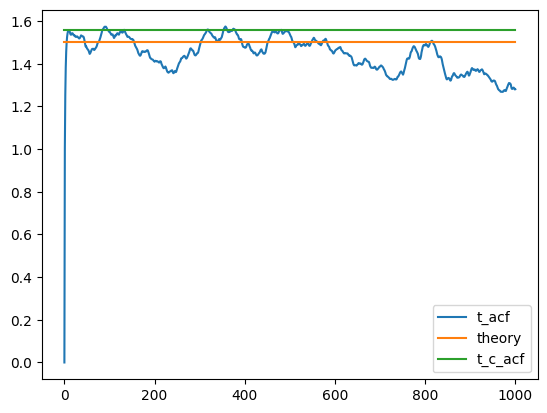

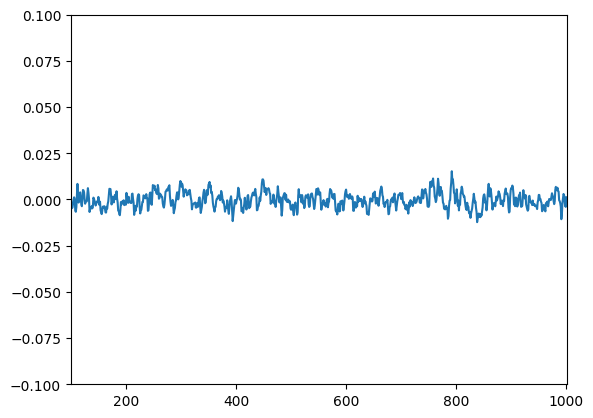

In [77]:
p = 0.5
N = 100000
ts, t_int_th = bivariate_ts(p,N)

import matplotlib.pyplot as plt

t_array, Aarray, k_crit = test_statsmodelacf(ts,1000,fft=False)
t_int_acf = t_array[k_crit]
error = err_t_int(t_int_acf,k_crit,N)
print("t_int acf: ",t_int_acf,"+/-",d, "; k_crit: ",k_crit)
plt.plot(t_array,label='t_acf')
plt.plot(np.ones(len(t_array))*t_int_th,label='theory')
plt.plot(np.ones(len(t_array))*t_int_acf,label='t_c_acf')
plt.legend()
plt.show()
plt.plot(Aarray)
plt.xlim(100,len(Aarray))
plt.ylim(-0.1,0.1)
plt.show()

In [113]:
# Analysis of ACF and ACT

def Autocorrelation_Analysis(ts_array,plot=False):
    M = len(ts_array)
    t_ints = np.zeros(M)
    d_t_ints = np.zeros(M)
    
    
    for i in range(len(ts_array)):
        ts = ts_array[i]
        N = len(ts)
        A_series, t_series, k_crit = Autocorrelation_series(ts)
        t_int_estimate = t_series[k_crit]
        error = err_t_int(t_int_estimate,k_crit,N)
        if plot:
            plt.plot(t_series,label='t_acf',color='black')
            #plt.plot(np.ones(len(t_series))*t_int_estimate,label='t_c_acf',color='red',linewidth = 0.5)
            #plt.plot(np.ones(len(t_series))*(t_int_estimate+error),label='t_c_acf_err+',color='red',linewidth=0.5,linestyle='dashed')
            #plt.plot(np.ones(len(t_series))*(t_int_estimate-error),label='t_c_acf_err-',color='red',linewidth=0.5,linestyle='dashed')
            
            plt.errorbar([k_crit],[t_int_estimate],yerr=[error],fmt='o',label='t_c_acf',markersize=0.1,color="red",capsize=2,linewidth=1)
            plt.annotate(str(round(t_int_estimate,2)),xy=(k_crit,t_int_estimate),xytext=(k_crit,t_series[k_crit]+error))
        
        #plt.legend()
        t_ints[i] = t_int_estimate
        d_t_ints[i] = error
    return t_ints, d_t_ints,k_crit

@njit
def Autocorrelation_series(ts):
    N = len(ts)

    A = np.zeros(N)
    t = np.zeros(N)

    t_int = 0.5

    k_crit = 0
    k_max = N

    mean_ts = np.mean(ts)
    var_ts = np.var(ts)

    check = True

    for k in range(1,N):
        if k is k_max:
            break
        ts1 = ts[k:]
        ts2 = ts[:-k]
        a1 = np.mean(ts1*ts2)
        a2 = mean_ts**2
        a = (a1-a2)/var_ts
        A[k] = a
        t_int += a
        t[k] = t_int
        
        if crit(t_int,k) and check:
            k_crit = k
            k_max = get_kmax(k_crit,N)
            check = False

        
    A_reshaped = A[:k_max]
    t_reshaped = t[:k_max]
    return A_reshaped, t_reshaped, k_crit
@njit
def get_kmax(k_crit,N):
    return min(10*k_crit,N)

(array([1.55621979, 1.98383003]), array([0.03189302, 0.04435979]), 12)

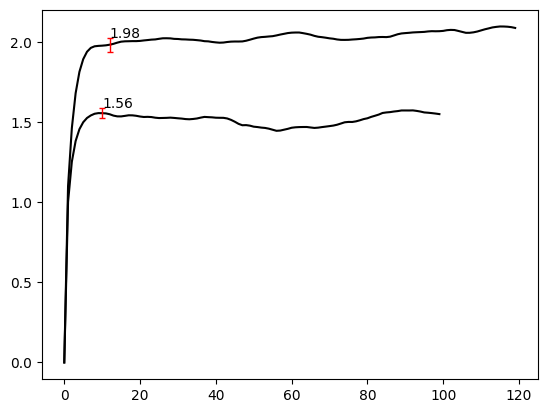

In [114]:
As, t_ints, k_crit = Autocorrelation_series(ts)

p2 = 0.6
ts2, _ = bivariate_ts(p2,N)
Autocorrelation_Analysis([ts,ts2],plot=True)